The first step is to import the OpenMC python library.  This library is an interface to OpenMC that faciliates the generation of input files.

In [1]:
import openmc
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Materials

The basic materials for this problem are 3.2% enriched UO2, Zircaloy-4, and water with 650 ppm boron. The OpenMC python API contains some convenience functions that faciliate certain tasks. The user has a choice to either use the add_nuclide function to add individual nuclides of the material, but they can also use the add_element function that will automatically populate the nuclides with their natural isotopics.  There is one exception to this rule, in the case of uranium, there is a special enrichment rule that can be used to compute the proper ratio of U-235 and U238 (U-234 is also added according to some special rules that work for low enrichment fuel (<5%)).

In [2]:
uo2 = openmc.Material(name='fuel')
uo2.add_element('U', 1, enrichment=3.2)
uo2.add_element('O', 2)
uo2.set_density('g/cc', 10.341)

In [3]:
zirc = openmc.Material()
zirc.add_element('Zr', 100.0, 'wo')
zirc.set_density('g/cm3', 6.55)

Another popular convenience function is the borated water model.  This function will create a water material with a given boron concentration with density at a given temperature (default 294K).  The borated water model will also automatically add the thermal neutron scattering file to the material.  If using a different moderator, this input must be added separately using the .add_sab function.

In [4]:
water = openmc.model.borated_water(650)

In this example, 650 ppm (weight fraction) of natural boron is added and converted to nuclide densities which will be used by OpenMC.  If temperature and pressure are not provided, the water density is taken at 293K and atmospheric pressure.

In [5]:
materials = openmc.Materials([uo2, water, zirc])

Once the materials completed, we can export to the XML format used by the OpenMC executable.

In [6]:
materials.export_to_xml()

In [7]:
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="fuel">
    <density units="g/cc" value="10.341" />
    <nuclide ao="0.0002895591829726249" name="U234" />
    <nuclide ao="0.03239590764444486" name="U235" />
    <nuclide ao="0.9671661443552968" name="U238" />
    <nuclide ao="0.00014838881728587684" name="U236" />
    <nuclide ao="1.999242" name="O16" />
    <nuclide ao="0.000758" name="O17" />
  </material>
  <material id="2">
    <density units="g/cm3" value="6.55" />
    <nuclide name="Zr90" wo="50.706117510089236" />
    <nuclide name="Zr91" wo="11.180887455130357" />
    <nuclide name="Zr92" wo="17.278101460711323" />
    <nuclide name="Zr94" wo="17.89110434223899" />
    <nuclide name="Zr96" wo="2.943789231830121" />
  </material>
  <material id="3" temperature="293.0">
    <density units="g/cc" value="0.9988861747099562" />
    <nuclide ao="0.11095219683481908" name="H1" />
    <nuclide ao="1.7282386693958438e-05" name="H2" />
    <nu

## Geometry

These parameters define a simple PWR pin with fuel, gap and clad surrounded by water.

In [8]:
radius_fuel = 0.3922
radius_gap = 0.4001
radius_clad = 0.4572
pitch = 1.26
zmax = 10.0

## Surfaces

Surfaces in this case are defined using simple cylinders infinite in the z-direction centered at the origin.  A convenience function is used to define a rectangular_prism instead of defining 4 surfaces.  Additionally, upper and lower z-planes are defined to bound the problem in z.

In [9]:
rfo = openmc.ZCylinder(r=radius_fuel)
rci = openmc.ZCylinder(r=radius_gap)
rco = openmc.ZCylinder(r=radius_clad)
xy_box = openmc.model.rectangular_prism(pitch, pitch, boundary_type='reflective')
z0 = openmc.ZPlane(z0=-zmax, boundary_type='reflective')
z1 = openmc.ZPlane(z0=zmax, boundary_type='reflective')

Monte Carlo always simulates particles in a 3D environment, so when modelling a 2D pin cell we could technically leave the z-axis undefined but it is common practice to cap the lower and upper z planes with reflective bounds to avoid particles with very large z-values.  Caution should be taken not to make the planes too close to each other to avoid slowdown from constantly hitting the boundary and reflecting.

## Cells

Once we have surfaces, we can define cells using the +/- notation and fill the cells with our materials.

In [10]:
fuel = openmc.Cell(name='fuel', fill=uo2)
fuel.region = -rfo & +z0 & -z1
gap = openmc.Cell(name='gap')
gap.region = +rfo & -rci & +z0 & -z1
clad = openmc.Cell(name='clad', fill=zirc)
clad.region = +rci & -rco & +z0 & -z1
mod = openmc.Cell(name='moderator', fill=water)
mod.region = +rco & xy_box & +z0 & -z1
root = openmc.Universe(cells=(fuel, gap, clad, mod))
geometry = openmc.Geometry(root)

geometry.export_to_xml()

In [11]:
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" name="1.6% Fuel" region="-1" universe="1" />
  <cell id="2" material="2" name="1.6% Clad" region="1 -2" universe="1" />
  <cell id="3" material="3" name="1.6% Moderator" region="2" universe="1" />
  <cell fill="1" id="4" name="root cell" region="3 -4 5 -6 7 -8" universe="0" />
  <surface coeffs="0.0 0.0 0.39218" id="1" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.4572" id="2" type="z-cylinder" />
  <surface boundary="reflective" coeffs="-0.63" id="3" type="x-plane" />
  <surface boundary="reflective" coeffs="0.63" id="4" type="x-plane" />
  <surface boundary="reflective" coeffs="-0.63" id="5" type="y-plane" />
  <surface boundary="reflective" coeffs="0.63" id="6" type="y-plane" />
  <surface boundary="reflective" coeffs="-10.0" id="7" type="z-plane" />
  <surface boundary="reflective" coeffs="10.0" id="8" type="z-plane" />
</geometry>


# Settings

The last input needed is the settings file that define the run parameters.  Monte Carlo computes tallies over a series of batches, however initial batches must be discarded until we have achieved a proper distribution of the fission source.  In the case of a fully reflected pin cell, very few discarded/inactives batches are needed since our initial guess is a uniformly distributed source in the fuel which matches the final solution closely.  In the case of a very long pin, the source distribution will evolve slowly and more batches must be discarded.

In [12]:
settings = openmc.Settings()

In [13]:
#TODO: how many batches/particles are needed for good cross sections?
settings.batches = 50
settings.inactive = 20
settings.particles = 10000

In [14]:
# Set the initial source to a flat distribution born only in the fuel.
space = openmc.stats.Box((-radius_fuel, -radius_fuel, -zmax),
     (radius_fuel, radius_fuel, zmax), only_fissionable=True)
settings.source = openmc.Source(space=space)

In [15]:
settings.export_to_xml()

In [16]:
# Export to XML and run.
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

When running multiple OpenMC in the same notebook, make sure to clear some of the generated output files.

In [17]:
!rm *.h5

# Shannon Entropy

## Source Convergence
 
There is no easy way to determine convergence of the source in a Monte Carlo calculation.  As we will see later in the semester, in deterministic calculations, we can define convergence criteria on both the eigenvalue and the eigenvector, and the simulation stops when these criteria are reached.  In Monte Carlo, we must first converge the source distribution (similar to the eigenvector) by discarding the contribution of many cycles, and then accumulate many additional cycles for statistical purposes.

The best tool to evaluate fission source stationarity is a metric called Shannon entropy. Shannon entropy is a concept from information theory that characterizes how much "information" a bit stream stores. In the context of eigenvalue calculations, it has been shown that when a source distibution is discretized over a mesh, the entropy of the source probability converges as the distribution itself reaches stationarity.

Shannon entropy is defined as
 
 $$ H = - \sum_i p_i \log_2 p_i $$
 
where $p_i$ is the fraction of source particles in mesh cell $i$. The `Settings` object in OpenMC allows us to specify a mesh over which entropy should be calculated. Note that unlike MCNP, the entropy is not automatically calculated otherwise.

In [18]:
radius_fuel = 0.3922
radius_gap = 0.4001
radius_clad = 0.4572
pitch = 1.26
zmax = 100.0

In [19]:
rfo = openmc.ZCylinder(r=radius_fuel)
rci = openmc.ZCylinder(r=radius_gap)
rco = openmc.ZCylinder(r=radius_clad)
xy_box = openmc.model.rectangular_prism(pitch, pitch, boundary_type='reflective')
z0 = openmc.ZPlane(z0=-zmax, boundary_type='vacuum')
z1 = openmc.ZPlane(z0=zmax, boundary_type='vacuum')

In [20]:
fuel = openmc.Cell(name='fuel', fill=uo2)
fuel.region = -rfo & +z0 & -z1
gap = openmc.Cell(name='gap')
gap.region = +rfo & -rci & +z0 & -z1
clad = openmc.Cell(name='clad', fill=zirc)
clad.region = +rci & -rco & +z0 & -z1
mod = openmc.Cell(name='moderator', fill=water)
mod.region = +rco & xy_box & +z0 & -z1
root = openmc.Universe(cells=(fuel, gap, clad, mod))
geometry = openmc.Geometry(root)

geometry.export_to_xml()

The settings file will define a number of total batches and a number of batches to be discarded.  The number to discard is not known a priori, and we can use Shannon entropy to verify that the number of discarded batches was sufficiently large.  Shannon entropy relies on a mesh that encompasses the fissile material of the problem.  The fission sites are then counted in each element of the mesh to form the distribution function on which Shannon entropy is to be evaluated.  In this case, our problem is a long pin of 200.0 cm with a very small radial dimension, so the Shannon entropy mesh was selected to have 10 axial bins.  An additional important element is the starting source.  The closer the stating source is to the stationary source, the less discarded batches are needed.  In this example, we have a uniform source covering the entire pin cell radially and axially, but the stationary source will have a cosine shape axially.

In [21]:
settings = openmc.Settings()

settings.batches = 200
settings.inactive = 20
settings.particles = 20000

# Set the initial source to a flat distribution born only in the fuel.
space = openmc.stats.Box((-radius_fuel, -radius_fuel, -zmax),
     (radius_fuel, radius_fuel, zmax), only_fissionable=True)
settings.source = openmc.Source(space=space)

entropy_mesh = openmc.RegularMesh()
entropy_mesh.lower_left = (-pitch/2, -pitch/2, -zmax)
entropy_mesh.upper_right = (pitch/2, pitch/2, zmax)
entropy_mesh.dimension = (1, 1, 10)

settings.entropy_mesh = entropy_mesh

settings.export_to_xml()

In [23]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

       92/1    1.28048    3.17695    1.27656 +/- 0.00120
       93/1    1.26939    3.17367    1.27647 +/- 0.00119
       94/1    1.28836    3.17107    1.27663 +/- 0.00119
       95/1    1.27623    3.16615    1.27662 +/- 0.00117
       96/1    1.29278    3.15786    1.27683 +/- 0.00117
       97/1    1.28317    3.15246    1.27692 +/- 0.00116
       98/1    1.28115    3.15368    1.27697 +/- 0.00115
       99/1    1.26205    3.15290    1.27678 +/- 0.00115
      100/1    1.26668    3.15400    1.27665 +/- 0.00114
      101/1    1.27219    3.15870    1.27660 +/- 0.00113
      102/1    1.29256    3.15815    1.27679 +/- 0.00113
      103/1    1.27086    3.15974    1.27672 +/- 0.00112
      104/1    1.28986    3.15652    1.27688 +/- 0.00112
      105/1    1.29073    3.15994    1.27704 +/- 0.00112
      106/1    1.27795    3.15618    1.27705 +/- 0.00110
      107/1    1.30346    3.15993    1.27736 +/- 0.00113
      108/1    1.28367    3.15376    1.27743 +/- 0.00112
      109/1    1.26472    3.148

After the run, we can plot the Shannon entropy and determine when it becomes stationary.  This approach is very qualitative and depends on the mesh selected and the number of particles per batches.  Many attemps have been made to develop more automated metrics to help determine stationarity but none are broadly accepted and used.

From the plot below, the Shannon entropy plot indicates that we would probably need ~125 batches to be discarded.

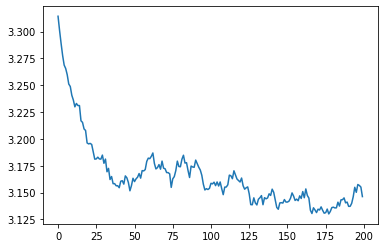

In [24]:
sp = openmc.StatePoint('statepoint.200.h5')
plt.plot(range(sp.n_batches), sp.entropy)

If we only looked at the eigenvalue of the system, we could be led to believe that very few discarded batches were needed.

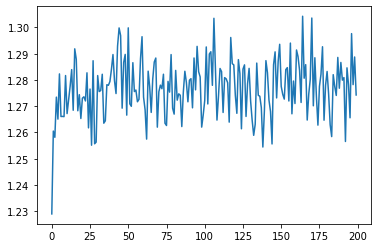

In [25]:
plt.plot(range(sp.n_batches), sp.k_generation)

Once again, you must delete some of the output files and also the statepoint variable before running the code again.

In [26]:
!rm *.h5

In [27]:
del sp